# Machine Learning Workshop
## 26 January 2021
### Pinto Research Group 
### Workshop led by Ben Gincley and Chris Anderson

## About this dataset:
The dataset includes 80x80pixel images of polystyrene microspheres used to calibrate instruments like flow cytometers or microscopes.<br /><br />
The dataset is comprised of 4 microsphere sizes: 4.5um, 6um, 10um, and 15um microspheres.<br /><br />
For Classification, class labels include both in-focus (if) and out-of-focuse (oof) images of each size, as well as debris and background noise picked up on the digital microscope.<br />
For Regression, the sphere size (in micrometers) is denoted in the 'object_size' column of the 'features' datatables. Debris and background are listed as having 'object_size' = 0.<br /><br />
Sample sizes are as follows: In-Focus - 200 | Out-of-Focus - 100 | Debris/Background - 60

In [1]:
## Import libraries
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from skimage import io, img_as_float
import support as s

## Visualize Samples

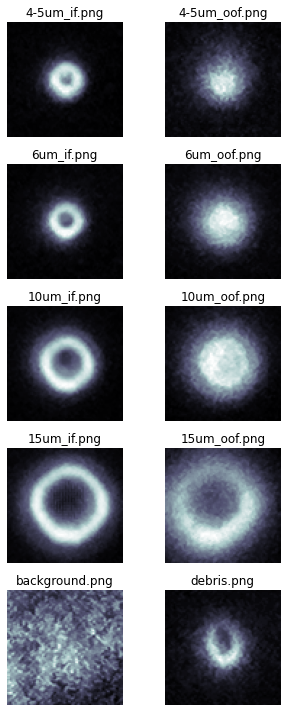

In [2]:
imdir = './data/images/_samples/'
ic = io.ImageCollection(imdir+'*.png')
len(ic)
#plt.imshow(imcollection[0])
cm = 'bone'
f, axes = plt.subplots(nrows = 5, ncols = len(ic)//5, figsize=(5,10))
axes = axes.ravel()
for ax in axes:
    ax.axis('off')
for i, image in enumerate(ic):
    image = img_as_float(image)
    axes[i].imshow(image,cmap=cm)
    axes[i].set_title(os.path.basename(ic.files[i]))
plt.tight_layout()

## Import and Check Data

In [3]:
# Import data and create initial data table (dataframe)
root_directory = './data/_annotations/'
root_directory2 = './data/_features/'

df_list = s.importData(root_directory,'.csv', verbose=False)
df_list2 = s.importData(root_directory2,'.csv', verbose=False)

df1 = s.concatenateDFs(df_list)
df2 = s.concatenateDFs(df_list2)

df_annotated = s.mergeDFs(df_list2,df_list)

df = s.concatenateDFs(df_annotated)

10 '.csv' files found in this directory.
10 '.csv' files found in this directory.


In [4]:
print(f"Dataframe shape: {df.shape}")
df.head(5)

Dataframe shape: (1320, 34)


,area,bbox_area,convex_area,solidity,perimeter,euler_number,centroid-0,centroid-1,eccentricity,equivalent_diameter,...,distance_bin_4,distance_bin_5,distance_bin_6,distance_bin_7,distance_bin_8,distance_bin_9,patchID,patchsize,object_size,celltype
0,505,728,536,0.942164,86.911688,1,39.390099,39.578218,0.163968,25.357168,...,70,60,46,34,20,0,0,80,4.5,4-5um_if
1,619,924,691,0.895803,108.639610,0,30.547658,33.268174,0.430561,28.073747,...,111,94,75,55,33,22,1,80,4.5,4-5um_if
2,618,896,667,0.926537,100.018290,1,39.574434,39.741100,0.516404,28.051061,...,79,66,58,46,33,20,2,80,4.5,4-5um_if
3,592,841,648,0.913580,99.083261,1,39.694257,40.319257,0.373535,27.454650,...,77,66,56,42,27,19,3,80,4.5,4-5um_if
4,518,702,544,0.952206,86.426407,1,39.741313,40.162162,0.296388,25.681474,...,70,60,48,33,28,0,4,80,4.5,4-5um_if


## Clean Dataframe

In [5]:
# Filter low-abundance classes with support function
df = s.filterByFreq(df, 'celltype', 10)
# Rename classes using 'reClass' support function
labels = df['celltype'][:]
unique_labels = df['celltype'].unique()
print(f"Unique Labels in 'celltype' column of df: {unique_labels}")
# Note that 'labels' is a direct memory reference to the dataframe, so the dataframe gets rewritten
reclassdict = {'4.5um':['4-5um_if','4-5um_oof'],'6um':['6um_if','6um_oof'],'10um':['10um_if','10um_oof'],'15um':['15um_if','15um_oof'],}
labels = s.reClass(labels, reclassdict)
unique_labels = df['celltype'].unique()
print(f"Unique Labels in 'celltype' column of df: {unique_labels}")

Unique Labels in 'celltype' column of df: ['4-5um_if' '4-5um_oof' '6um_if' '6um_oof' '10um_if' '10um_oof' '15um_if'
 '15um_oof' 'background' 'debris']
Note: Labels should be of type: ndarray OR Series
Type passed:  <class 'pandas.core.series.Series'>
4.5um from ['4-5um_if', '4-5um_oof']
6um from ['6um_if', '6um_oof']
10um from ['10um_if', '10um_oof']
15um from ['15um_if', '15um_oof']
Unique Labels in 'celltype' column of df: ['4.5um' '6um' '10um' '15um' 'background' 'debris']


## Prepare inputs for model training

In [6]:
# Drop Target column(s) and any metadata
print(df.shape)
df = df.drop(columns=['celltype','patchID','patchsize','object_size'])
print(df.shape)

(1320, 34)
(1320, 30)


In [9]:
# Prepare feature vector and class labels (target) vector
feature_names = list(df.columns)
features = np.asarray(df)
normalized_features = ((features-features.min(axis=0))/(features.max(axis=0)-features.min(axis=0)))
print(f"Normalized Feature Vector: {normalized_features[0,:]}")
# Convert string class names to integers (some models don't handle mapping to strings well)
class_labels = np.zeros((len(labels)))
for n,l in enumerate(unique_labels):
    class_labels[l==labels] = int(n)
unique_classes = np.unique(class_labels)
sample_sizes = [sum(class_labels==i) for i in range(len(unique_classes))]
print(f"Unique classes (numerical): {unique_classes}")
print(f"Sample sizes: {sample_sizes}")

Normalized Feature Vector: [0.09617613 0.1126408  0.09683324 0.90842934 0.07194522 1.
 0.45769329 0.49313536 0.10559919 0.28584361 0.22454088 0.21772177
 0.34407296 0.46015411 0.60117127 0.59734513 0.09593527 0.72051902
 0.11250857 0.236435   0.88903538 0.04792043 0.09388186 0.09756098
 0.07981756 0.08010681 0.06488011 0.07762557 0.05649718 0.        ]
Unique classes (numerical): [0. 1. 2. 3. 4. 5.]
Sample sizes: [300, 300, 300, 300, 60, 60]


In [10]:
# Balance class weights for algorithms that take class weights as parameters:
sample_weights = 1 / (sample_sizes / sum(sample_sizes))
sample_weights = sample_weights/sample_weights.max()
weights = {unique_classes[i]: sample_weights[i] for i in range(len(unique_classes))} 
print(f"Class weights: {weights.values()}")

Class weights: dict_values([0.2, 0.2, 0.2, 0.2, 1.0, 1.0])


In [11]:
tree = DecisionTreeClassifier(class_weight = weights)

from the documentation...
#### class_weight: dict, list of dict or “balanced”, default=None
##### Weights associated with classes in the form {class_label: weight}. 
##### The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)) <br />
Okay so it's already a built-in. Easy enough.

## Separate the Training and Testing Data

In [15]:
xTrain, xTest, yTrain, yTest = train_test_split(normalized_features, class_labels, 
                                                    test_size=0.2,random_state=4)

print(f"xTrain shape: {xTrain.shape}")
print(f"xTest shape: {xTest.shape}")
print(f"yTest shape: {yTest.shape}")

xTrain shape: (1056, 30)
xTest shape: (264, 30)
yTest shape: (264,)


In [13]:
clf = DecisionTreeClassifier(max_depth=3,max_leaf_nodes=6,criterion="entropy",class_weight = 'balanced')
clf.fit(xTrain,yTrain)
yPredict = clf.predict(xTest)
report = metrics.classification_report(yTest,yPredict)
print(report)
print(metrics.confusion_matrix(yTest, yPredict))

              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        67
         1.0       0.88      0.96      0.92        51
         2.0       0.98      0.98      0.98        57
         3.0       0.97      1.00      0.98        65
         4.0       1.00      0.71      0.83        14
         5.0       0.26      0.90      0.40        10

    accuracy                           0.86       264
   macro avg       0.85      0.86      0.81       264
weighted avg       0.94      0.86      0.88       264

[[39  6  0  0  0 22]
 [ 0 49  1  0  0  1]
 [ 0  1 56  0  0  0]
 [ 0  0  0 65  0  0]
 [ 0  0  0  1 10  3]
 [ 0  0  0  1  0  9]]


Tune the hyperparameters (max_depth, max_leaf_nodes, etc.) to your heart's content until you get pretty dang good performance.
But, how might this model perform on unseen data - unseen to both the model and the model architect? How can we fairly evaluate what we've created?

## Training, Validation, Testing 

In [19]:
# Train-Validation-Test Split
# Train is what the model sees and learns from
# Validation provides feedback to you during training, to tune hyperparameters for better performance
# Test is 'holdout' group of 'wild' data for final model evaluation

# Separate Train-Validation and Test sets
xTrainset, xTest, yTrainset, yTest = train_test_split(normalized_features, class_labels, 
                                                    test_size=0.15,random_state=1)
# Separate Train and Validation sets
xTrain, xVal, yTrain, yVal = train_test_split(xTrainset, yTrainset, 
                                                    test_size=0.3,random_state=1)
print(f"yTrain shape: {yTrain.shape}")
print(f"yVal shape: {yVal.shape}")
print(f"yTest shape: {yTest.shape}")

yTrain shape: (785,)
yVal shape: (337,)
yTest shape: (198,)


[[52 16  0  0  1  7]
 [ 0 71  1  0  0  0]
 [ 0  0 70  0  0  0]
 [ 0  0  0 81  0  0]
 [ 0  5  0  1 12  2]
 [ 1  0  1  0  0 16]]
              precision    recall  f1-score   support

         0.0       0.98      0.68      0.81        76
         1.0       0.77      0.99      0.87        72
         2.0       0.97      1.00      0.99        70
         3.0       0.99      1.00      0.99        81
         4.0       0.92      0.60      0.73        20
         5.0       0.64      0.89      0.74        18

    accuracy                           0.90       337
   macro avg       0.88      0.86      0.85       337
weighted avg       0.91      0.90      0.89       337

Val Accuracy: 0.8961
Val Precision: 0.9145
Val Recall: 0.8961
Test Accuracy: 0.904


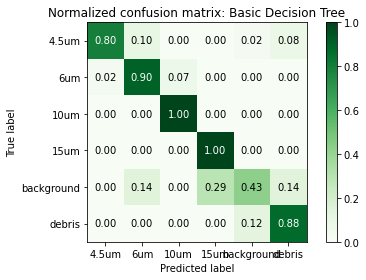

In [20]:
clf = DecisionTreeClassifier(max_depth=3,max_leaf_nodes=6,criterion="entropy",class_weight = 'balanced')
clf.fit(xTrain,yTrain)
yValPredict = clf.predict(xVal)
report = metrics.classification_report(yVal,yValPredict)
print(metrics.confusion_matrix(yVal, yValPredict))
print(report)
print(f"Val Accuracy: {np.round(metrics.accuracy_score(yVal,yValPredict),4)}")
print(f"Val Precision: {np.round(metrics.precision_score(yVal,yValPredict,average='weighted'),4)}")
print(f"Val Recall: {np.round(metrics.recall_score(yVal,yValPredict,average='weighted'),4)}")

# Final evaluation with help from support function to plot confusion matrix
yTestPredict = clf.predict(xTest)
s.confusionMatrixFxn(yTest,yTestPredict,unique_labels,title_add = 'Basic Decision Tree',
                     cm=plt.cm.Greens)
print(f"Test Accuracy: {np.round(metrics.accuracy_score(yTest,yTestPredict),4)}")

But again, how can we be sure that the validation set we're working from is representative of the whole sample? Changing the 'random_state' can have noticeable impact on performance...

## Cross Validation
https://scikit-learn.org/stable/modules/cross_validation.html

CV fold 0: 0.9378
CV fold 1: 0.9378
CV fold 2: 0.942
CV fold 3: 0.9375
CV fold 4: 0.9509
Mean: 0.9412, StDev: 0.0051
Test Accuracy: 0.9444


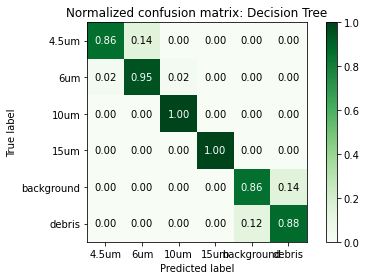

In [45]:
# Now with cross validation:
# Separate Train-Validation and Test sets
xTrainset, xTest, yTrainset, yTest = train_test_split(normalized_features, class_labels, 
                                                    test_size=0.15,random_state=1)

tree = DecisionTreeClassifier(criterion="entropy", class_weight = 'balanced', max_depth=8,
                             max_leaf_nodes=8, min_impurity_decrease=0.001)

scores = cross_val_score(tree, xTrainset, yTrainset, cv=5)
for n, cv in enumerate(scores):
    print(f"CV fold {n}: {np.round(cv,4)}")
print(f"Mean: {np.round(scores.mean(),4)}, StDev: {np.round(scores.std(),4)}")
# Final evaluation with help from support function to plot confusion matrix
tree.fit(xTrainset,yTrainset)
yTestPredict = tree.predict(xTest)
s.confusionMatrixFxn(yTest,yTestPredict,unique_labels,title_add = 'Decision Tree',cm=plt.cm.Greens)
print(f"Test Accuracy: {np.round(metrics.accuracy_score(yTest,yTestPredict),4)}")

Mean of 5-fold cross validation very close to test accuracy - this makes it a pretty good predictor of test performance.

### Note:
TimeSeriesSplit is a variation of k-fold which returns first k folds as train set and the (k+1) th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

In [22]:
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
print(X)
print(y)
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)
for n, (train, test) in enumerate(tscv.split(X)):
     print(f"CV: {n} | Train: {train} | Test: {test}")

[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]
 [3 4]]
[1 2 3 4 5 6]
TimeSeriesSplit(max_train_size=None, n_splits=3)
CV: 0 | Train: [0 1 2] | Test: [3]
CV: 1 | Train: [0 1 2 3] | Test: [4]
CV: 2 | Train: [0 1 2 3 4] | Test: [5]


Okay, so as fun as it is to mess with hyperparameters...I've got other things to do. Can I automate this?

Actually, yes! Several approaches to finding performance maxima in hyperparameter space:<br />
https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/<br />
And, they can be used in tandem. For example: a random search to find most promising region, then grid search within that region.

## Automated Hyperparameter Tuning with Grid Searches
Random grid search, Brute-force grid search

In [37]:
# Random Search
# Number of features to consider at every split
class_weights = ['balanced', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 40, num = 11)]
max_depth.append(None)
# Minimum impurity
min_impurity_decrease = [float(x) for x in np.linspace(0, 0.01, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'class_weight': class_weights,
               'max_depth': max_depth,
               #'min_samples_split:': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_impurity_decrease': min_impurity_decrease}
print(random_grid)

{'class_weight': ['balanced', None], 'max_depth': [3, 6, 10, 14, 17, 21, 25, 28, 32, 36, 40, None], 'min_samples_leaf': [1, 2, 4, 8], 'min_impurity_decrease': [0.0, 0.0011111111111111111, 0.0022222222222222222, 0.003333333333333333, 0.0044444444444444444, 0.005555555555555556, 0.006666666666666666, 0.0077777777777777776, 0.008888888888888889, 0.01]}


In [38]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=2, n_jobs = -1)
# Fit the random search model
dt_random.fit(xTrain, yTrain)
print(f"Optimum from random search: {dt_random.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Optimum from random search: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.008888888888888889, 'max_depth': 25, 'class_weight': 'balanced'}


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


In [39]:
# Brute-Force Grid Search
param={'max_depth':np.arange(10,20,11),
       'min_samples_split':np.arange(2,6,5),
       'min_samples_leaf':np.arange(1,4,4),
       'min_impurity_decrease':np.arange(0.007,0.010,4)}
dt = DecisionTreeClassifier()
GridS=GridSearchCV(dt, param, cv=5)
GridS.fit(xTrain,yTrain)
print(f"Optimum from grid search: {GridS.best_params_}")

Optimum from grid search: {'max_depth': 10, 'min_impurity_decrease': 0.007, 'min_samples_leaf': 1, 'min_samples_split': 2}


Test Accuracy: 0.9545


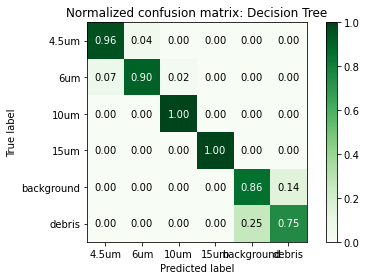

In [41]:
# Optimum model
clf = DecisionTreeClassifier(criterion="entropy", class_weight = None, max_depth=10,
                             max_leaf_nodes=40, min_impurity_decrease=0.007)
clf.fit(xTrainset,yTrainset)
yTestPredict = clf.predict(xTest)
s.confusionMatrixFxn(yTest,yTestPredict,unique_labels,title_add = 'Decision Tree',cm=plt.cm.Greens)
print(f"Test Accuracy: {np.round(metrics.accuracy_score(yTest,yTestPredict),4)}")

I think we've squeezed this lemon (tree) for all its juice...what do you mean "more trees?"

## Ensemble Learning: Random Forest

Test Accuracy: 0.9798


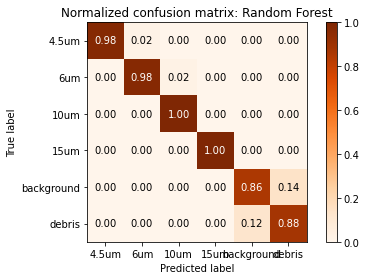

In [44]:
## Random Forest
rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 8, random_state = 2)
rf.fit(xTrainset, yTrainset);

rf_predictions = rf.predict(xTest)
errors = np.not_equal(yTest,rf_predictions)
nErrors = np.sum(errors)
errorRate = nErrors/len(yTest)
accuracy = 100*(1-errorRate)

print(f"Test Accuracy: {np.round(metrics.accuracy_score(yTest,rf_predictions),4)}")
s.confusionMatrixFxn(yTest,rf_predictions,unique_labels,title_add = 'Random Forest',cm=plt.cm.Oranges)

So how are these models achieving such high accuracy? Are a small handful of features really important, or does everything contribute a little bit?

## Feature Importances

[('obj_intensity_sum', 0.462), ('mean_intensity', 0.216), ('major_axis_length', 0.167), ('entropy', 0.079), ('distance_bin_1', 0.076)]


(0.0, 0.5)

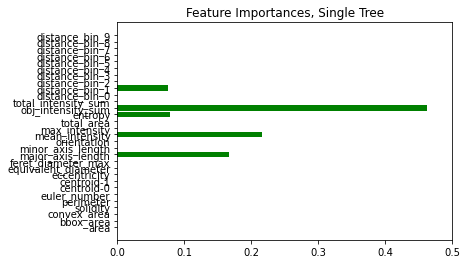

In [47]:
# Feature Importances from Decision Tree
# Find important values
importances = tree.feature_importances_
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print(feature_importances[0:5])
plt.figure()
plt.barh(feature_names,importances,color='g')
plt.title("Feature Importances, Single Tree")
plt.xlim([0,0.5])

[('obj_intensity_sum', 0.139), ('entropy', 0.097), ('minor_axis_length', 0.095), ('distance_bin_4', 0.091), ('total_intensity_sum', 0.075)]


(0.0, 0.5)

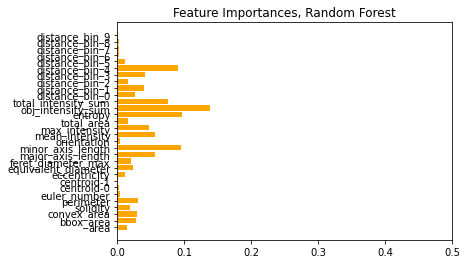

In [49]:
#%% Importances from Forest
# Find important values
importances = rf.feature_importances_
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print(feature_importances[0:5])
plt.figure()
plt.barh(feature_names,importances,color='orange')
plt.title("Feature Importances, Random Forest")
plt.xlim([0,0.5])

The Random Forest allows full feature set to be more 'democratic' if there are no 1:1 feature:class relationships.